In [1]:
# COMMENT FROM NEW BRANCH
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Noise Reduction Methods
import scipy.signal as ss  # Signal processing
from scipy.signal import savgol_filter, wiener
from skimage.restoration import denoise_tv_chambolle, calibrate_denoiser
from skimage.restoration.j_invariant import _invariant_denoise
import pyyawt  # Yet Another Wavelet Transform
import dtcwt  # Dual Tree Continuous Wavelet Transform

from numpy.lib.stride_tricks import as_strided
from functools import partial

# Signal generating functions



In [2]:
# Noise
def add_gwn(clean_signal, sqrt_snr=5, sigma=None):
    """
    Adds Gaussian White Noise to given clean signal
    Parameters
    ----------
    clean_signal: 1D np.array
    sqrt_snr: float
        Desired SNR of clean signal to noisy signal
    sigma: float
        Standard deviation of noise. If provided, adds constant noise of given standard deviation.
        Otherwise, calculates noise standard deviation based on desired SNR
    
    Returns
    -------
    noisy_signal: 1D np.array
        Clean signal with added GWN
    """
    if sigma is None:
        sigma = np.sqrt(np.mean(clean_signal**2) / np.mean(clean_signal ** 2))
    mu = 0
    gwn = np.random.default_rng().normal(mu, sigma, size=len(clean_signal))
    return clean_signal + gwn

In [7]:
def generate_test_signals(sig_len=11, sqrt_snr=2):
    """
    Generates clean and noisy test signals of length t and noise given by sqrt_snr.
    Noisy signals are clean signals corrupted with added constant Gaussian white noise
    Parameters
    ----------
    sig_len: int
        Power for dyadic signal length, i.e. len(X) = 2^sig_len
    sqrt_snr: float
        Square root of desired SNR for noise. Lower sqrt_snr means more noise.
        
    Returns
    -------
    t: 1D np.array
        Time vector equivalent to the indices of the signal
    clean_signal: dict
        Dictionary containing clean signals as 1D np.array
    noisy_signal: dict
        Dictionary containing noisy signals as 1D np.array
    """
    noisy_signal = {}
    clean_signal = {}
    t = np.arange(2**sig_len)
    f = len(t)/10000 * 1000
    for sig_name in ['blocks', 'bumps', 'heavy sine']:
        clean_signal[sig_name], noisy_signal[sig_name] = pyyawt.denoising.wnoise(sig_name, sig_len, SQRT_SNR=sqrt_snr)
    
    # square_wave
    square_wave = ss.square(2*np.pi/1 * t/f, 0.5)

    # sawtooth_wave
    sawtooth_wave = ss.sawtooth(2*np.pi/2 * t/f, 0.2)

    # simple_sine
    simple_sine = np.sin(2*np.pi/2*t/f)
    
    # sum_sine
    t4 = np.tile(t/f, (4, 1))
    freqs = 2*np.pi*np.array([0.4, 0.7, 1.2, 1.4])
    sum_sine = np.sum(np.sin(freqs * t4.T).T, axis=0)
    sum_sine = sum_sine / np.max(sum_sine, axis=0)

    # poly_cosine
    poly = np.poly1d([0.025, -0.36, 1.25, 2.0])
    poly_cosine = ss.sweep_poly(t/f, poly)
    
    sig_names = ['square_wave', 'sawtooth_wave', 'simple_sine', 'sum_sine', 'poly_cosine']
    signals = [square_wave, sawtooth_wave, simple_sine, sum_sine, poly_cosine]
    for sig_name, signal in zip(sig_names, signals):
        clean_signal[sig_name] = signal
        noisy_signal[sig_name] = add_gwn(signal, sqrt_snr=sqrt_snr)
    return t, clean_signal, noisy_signal

In [11]:
t, clean_sig, noisy_sig = generate_test_signals(sig_len=14)

In [12]:
noisy_sig.keys()

dict_keys(['blocks', 'bumps', 'heavy sine', 'square_wave', 'sawtooth_wave', 'simple_sine', 'sum_sine', 'poly_cosine'])

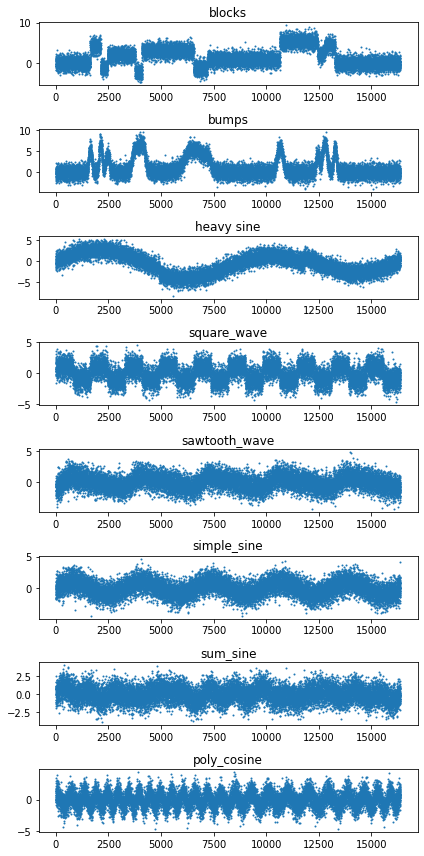

In [23]:
N = len(noisy_sig.keys())

fig, axs = plt.subplots(N, 1, figsize=(6, 12))

for ax, k in zip(axs, noisy_sig.keys()):
    ax.plot(t, noisy_sig[k], 'o', ms=1)
    ax.set_title(k)
plt.tight_layout()
plt.show()

# Denoising Functions

In [29]:
from denoising_functions import *

In [31]:
x = noisy_sig['blocks']

In [32]:
x.shape

(16384,)

In [87]:
# x_den = direct_tvd(x, weight=2)
x_den = DTCWTNeighCoeff(x, nlevels=5)
x_den = wden_softSURE(x, level=5)
x_den = wavelet_denoising(x, level=5)
x_den = denoise_tv_chambolle(x, weight=2)

In [60]:
from scipy.signal import savgol_filter, wiener
# x_den = savgol_filter(x, 651, 5)
x_den = wiener(x, mysize=64)

In [72]:
def pandas_rolling(x, func=np.mean, wlen=64):
    X = pd.Series(x)
    X_den = X.rolling(wlen, min_periods=1, center=True).apply(func, raw=True)
    return X_den.values

In [86]:
def rolling_mean(x, wlen=64):
    X = pd.Series(x)
    X_den = X.rolling(wlen, min_periods=1, center=True).apply(np.mean, raw=True)
    return X_den.values


def rolling_median(x, wlen=64):
    X = pd.Series(x)
    X_den = X.rolling(wlen, min_periods=1, center=True).apply(np.median, raw=True)
    return X_den.values

In [82]:
x_den = pandas_rolling(x, func=np.median, wlen=123)

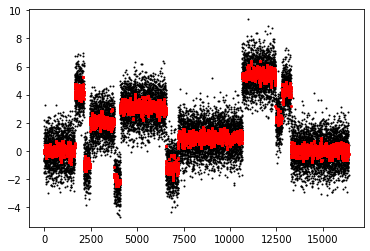

In [88]:
plt.plot(x, 'o', c='k', ms=1)
plt.plot(x_den, 'o', c='r', ms=2)
plt.show()

In [89]:
den_funcs = [savgol_filter, wiener, rolling_mean, rolling_median, direct_tvd, denoise_tv_chambolle, wavelet_denoising, wden_softSURE, DTCWTNeighCoeff]

In [90]:
den_func_names = [f.__name__ for f in den_funcs]

In [91]:
den_func_names

['savgol_filter',
 'wiener',
 'rolling_mean',
 'rolling_median',
 'direct_tvd',
 'denoise_tv_chambolle',
 'wavelet_denoising',
 'wden_softSURE',
 'DTCWTNeighCoeff']

In [114]:
import itertools
wlens = [16, 32, 64, 128, 256]
odd_wlens = [w-1 for w in wlens]
orders = [2, 3, 5, 7]
coeff_levels = [0, 1, 2, 3, 4, 5]
wavelets = ['db4', 'db8', 'sym4', 'sym8']
weights = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]

savgol_params = list(itertools.product(odd_wlens, orders))
wavelet_params = list(itertools.product(wavelets, orders))
func_params = {
    'savgol_filter': savgol_params,
    'wiener': wlens,
    'rolling_mean': wlens,
    'rolling_median': wlens,
    'direct_tvd': weights,
    'denoise_tv_chambolle': weights,
    'wavelet_denoising': wavelet_params,
    'wden_softSURE': wavelet_params,
    'DTCWTNeighCoeff': coeff_levels
}

In [107]:
from collections.abc import Iterable
for f in den_funcs:
    f_name = f.__name__
    params = func_params[f_name]
    for p in params:
        if isinstance(p, Iterable):
            x_den = f(x, *p)
            print(f_name + '_' + '_'.join([str(a) for a in p]))
        else:
            x_den = f(x, p)
            print(f_name + '_' + str(p))
        

savgol_filter_15_2
savgol_filter_15_3
savgol_filter_15_5
savgol_filter_15_7
savgol_filter_31_2
savgol_filter_31_3
savgol_filter_31_5
savgol_filter_31_7
savgol_filter_63_2
savgol_filter_63_3
savgol_filter_63_5
savgol_filter_63_7
savgol_filter_127_2
savgol_filter_127_3
savgol_filter_127_5
savgol_filter_127_7
savgol_filter_255_2
savgol_filter_255_3
savgol_filter_255_5
savgol_filter_255_7
wiener_16
wiener_32
wiener_64
wiener_128
wiener_256
rolling_mean_16
rolling_mean_32
rolling_mean_64
rolling_mean_128
rolling_mean_256
rolling_median_16
rolling_median_32
rolling_median_64
rolling_median_128
rolling_median_256
direct_tvd_0.001
direct_tvd_0.01
direct_tvd_0.1
direct_tvd_0.25
direct_tvd_0.5
direct_tvd_0.75
direct_tvd_1
direct_tvd_2
direct_tvd_5
direct_tvd_10
denoise_tv_chambolle_0.001
denoise_tv_chambolle_0.01
denoise_tv_chambolle_0.1
denoise_tv_chambolle_0.25
denoise_tv_chambolle_0.5
denoise_tv_chambolle_0.75
denoise_tv_chambolle_1
denoise_tv_chambolle_2
denoise_tv_chambolle_5
denoise_tv_cha

In [226]:
from skimage.metrics import mean_squared_error as MSE
from skimage.metrics import peak_signal_noise_ratio as PSNR
import time

results = {}
denoised_signals = {}
for sig_name, x in noisy_sig.items():
    df_res = pd.DataFrame()
    x_clean = clean_sig[sig_name]
    for f in den_funcs:
        # Get function and run denoising
        f_name = f.__name__
        params = func_params[f_name]
        for p in params:
            if isinstance(p, Iterable):
                ts_now = time.time()
                x_den = f(x, *p)
                ts_done = time.time()
                func_param_name = f_name + '_' + '_'.join([str(a) for a in p])
            else:
                ts_now = time.time()
                x_den = f(x, p)
                ts_done = time.time()
                func_param_name = f_name + '_' + str(p)
            # Get stats
            denoised_signals.setdefault(sig_name, {}).update({func_param_name: x_den})
            runtime = ts_done - ts_now
            data_range = int(np.max(x_clean) - np.min(x_clean))
            psnr = PSNR(x_clean, x_den, data_range=data_range)
            mse = MSE(x_clean, x_den)
            stat_dict = {'func_name': f.__name__,
                        'func_params': func_param_name,
                        'mse': mse,
                        'psnr': psnr,
                        'runtime_ms': runtime}
            df_res = df_res.append(stat_dict, ignore_index=True)
    results.update({sig_name: df_res})
    print(sig_name + ' done')

        

/home/trevor/.local/lib/python3.8/site-packages/pyyawt/dwt.py:471: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif (np.any(mode == modes)):


blocks done
bumps done
heavy sine done
square_wave done
sawtooth_wave done
simple_sine done
sum_sine done
poly_cosine done


In [173]:
df = results['heavy sine']

In [174]:
df.sort_values(by='psnr', ascending=False).groupby(by=['func_name']).head(1)

,func_name,func_params,mse,psnr,runtime_ms
67,wavelet_denoising,wavelet_denoising_sym8_2,0.007781,36.652839,0.000912
44,direct_tvd,direct_tvd_10,0.008289,36.377913,0.116641
29,rolling_mean,rolling_mean_256,0.009135,35.955759,0.105252
24,wiener,wiener_256,0.010628,35.298464,0.001901
16,savgol_filter,savgol_filter_255_2,0.010703,35.267861,0.002064
34,rolling_median,rolling_median_256,0.011311,35.028041,0.514864
82,wden_softSURE,wden_softSURE_sym4_7,0.011591,34.921898,0.003726
87,DTCWTNeighCoeff,DTCWTNeighCoeff_0,0.020810,32.380377,0.270998
54,denoise_tv_chambolle,denoise_tv_chambolle_10,0.045018,29.029148,0.006091


In [194]:
df_ranks = pd.DataFrame()
for k in results.keys():
    df = results[k]
    df_top = df.sort_values(by='mse').groupby(by=['func_name']).head(1).reset_index(drop=True)
    df_top['rank'] = df_top.index + 1
    df_top['signal'] = k
    df_ranks = df_ranks.append(df_top, ignore_index=True)

In [199]:
df_ranks.sort_values('rank').head(20)

,func_name,func_params,mse,psnr,runtime_ms,rank,signal
0,direct_tvd,direct_tvd_10,0.007173,38.344684,0.067951,1,blocks
54,rolling_mean,rolling_mean_256,0.004572,29.419396,0.107103,1,sum_sine
45,rolling_mean,rolling_mean_256,0.003582,30.479273,0.105805,1,simple_sine
36,rolling_mean,rolling_mean_256,0.004886,23.110775,0.106766,1,sawtooth_wave
27,direct_tvd,direct_tvd_10,0.009234,26.366709,0.069839,1,square_wave
18,wavelet_denoising,wavelet_denoising_sym8_2,0.007781,36.652839,0.000912,1,heavy sine
9,wden_softSURE,wden_softSURE_sym8_7,0.016091,34.836150,0.004507,1,bumps
63,savgol_filter,savgol_filter_255_3,0.007515,21.240708,0.002058,1,poly_cosine
28,wden_softSURE,wden_softSURE_sym4_7,0.033690,20.745594,0.003749,2,square_wave
1,DTCWTNeighCoeff,DTCWTNeighCoeff_0,0.033247,31.684459,0.268068,2,blocks


In [201]:
df_ranks.groupby('func_name')['mse'].agg('sum').sort_values()

func_name
direct_tvd              0.089352
wden_softSURE           0.135783
rolling_mean            0.151160
savgol_filter           0.166593
rolling_median          0.167315
wiener                  0.173167
DTCWTNeighCoeff         0.189414
wavelet_denoising       0.212898
denoise_tv_chambolle    0.397872
Name: mse, dtype: float64

In [204]:
df_ranks.groupby('func_name')['psnr'].agg('sum').sort_values(ascending=False)

func_name
direct_tvd              226.866749
rolling_mean            222.541026
wden_softSURE           215.271801
savgol_filter           213.755990
rolling_median          212.068719
wiener                  209.248001
wavelet_denoising       205.542186
DTCWTNeighCoeff         199.354945
denoise_tv_chambolle    171.854915
Name: psnr, dtype: float64

In [219]:
df_ranks.loc[df_ranks['rank'] <=3, ['func_params', 'signal', 'rank']]

,func_params,signal,rank
0,direct_tvd_10,blocks,1
1,DTCWTNeighCoeff_0,blocks,2
2,wden_softSURE_db4_7,blocks,3
9,wden_softSURE_sym8_7,bumps,1
10,savgol_filter_255_5,bumps,2
11,rolling_mean_64,bumps,3
18,wavelet_denoising_sym8_2,heavy sine,1
19,direct_tvd_10,heavy sine,2
20,rolling_mean_256,heavy sine,3
27,direct_tvd_10,square_wave,1


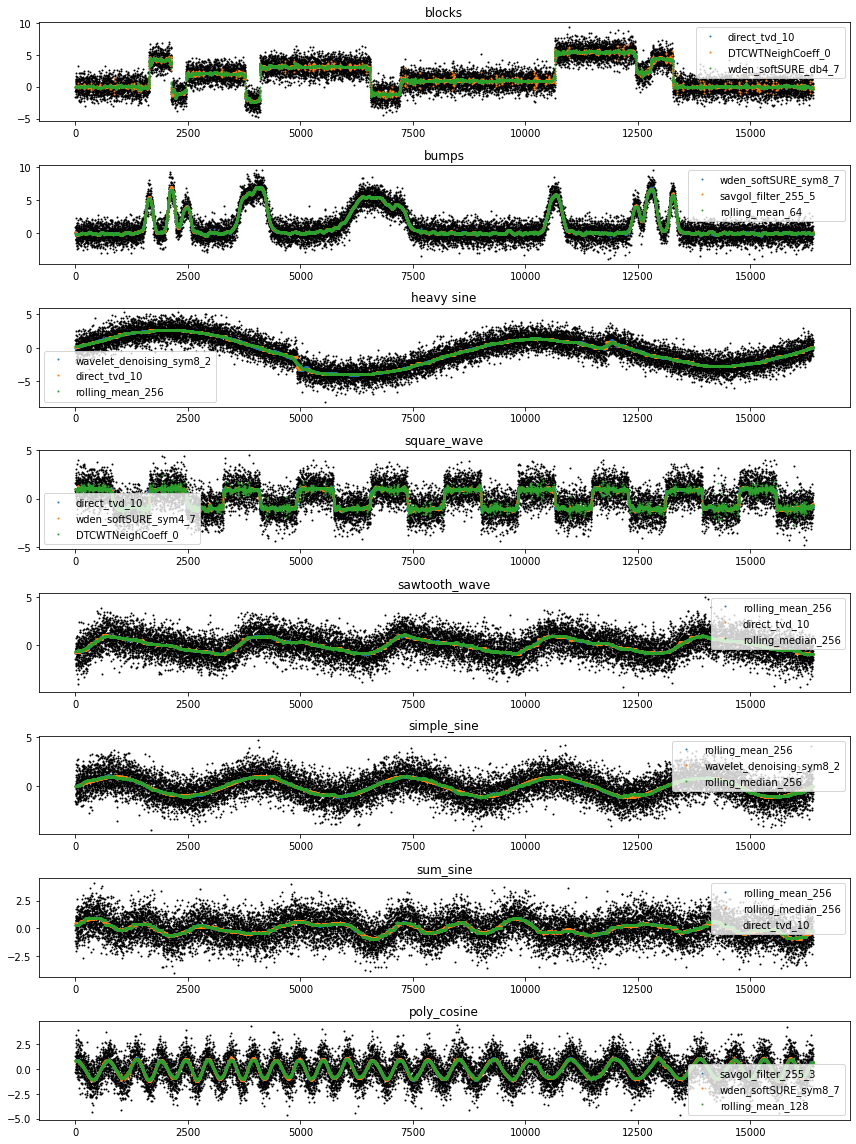

In [227]:
fig, axs = plt.subplots(8, 1, figsize=(12, 16))

for ax, signal in zip(axs, noisy_sig.keys()):
    ax.plot(noisy_sig[signal], 'o', color='k', ms=1)
    func_names = df_ranks.loc[(df_ranks['rank'] <=3) & (df_ranks['signal'] == signal), ['func_params']].values.flatten()
    for name in func_names:
        x_den = denoised_signals[signal][name]
        ax.plot(x_den, 'o', ms=1, label=name)
    ax.legend()
    ax.set_title(signal)
plt.tight_layout()
plt.show()


In [222]:
df_ranks.loc[(df_ranks['rank'] <=3) & (df_ranks['signal'] == signal), ['func_params']].values.flatten()

array(['direct_tvd_10', 'DTCWTNeighCoeff_0', 'wden_softSURE_db4_7'],
      dtype=object)

# Repeat 2048 long signal 8 times

In [230]:
t2, clean_sig2, noisy_sig2 = generate_test_signals(sig_len=11)

In [232]:
for name, sig_ary in clean_sig2.items():
    clean_sig2[name] = np.tile(sig_ary, 8)
for name, sig_ary in noisy_sig2.items():
    noisy_sig2[name] = np.tile(sig_ary, 8)

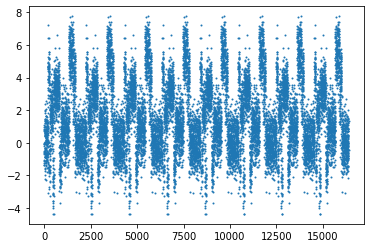

In [234]:
plt.plot(noisy_sig2['blocks'], 'o', ms=1)

In [235]:
results = {}
denoised_signals = {}
for sig_name, x in noisy_sig2.items():
    df_res = pd.DataFrame()
    x_clean = clean_sig2[sig_name]
    for f in den_funcs:
        # Get function and run denoising
        f_name = f.__name__
        params = func_params[f_name]
        for p in params:
            if isinstance(p, Iterable):
                ts_now = time.time()
                x_den = f(x, *p)
                ts_done = time.time()
                func_param_name = f_name + '_' + '_'.join([str(a) for a in p])
            else:
                ts_now = time.time()
                x_den = f(x, p)
                ts_done = time.time()
                func_param_name = f_name + '_' + str(p)
            # Get stats
            denoised_signals.setdefault(sig_name, {}).update({func_param_name: x_den})
            runtime = ts_done - ts_now
            data_range = int(np.max(x_clean) - np.min(x_clean))
            psnr = PSNR(x_clean, x_den, data_range=data_range)
            mse = MSE(x_clean, x_den)
            stat_dict = {'func_name': f.__name__,
                        'func_params': func_param_name,
                        'mse': mse,
                        'psnr': psnr,
                        'runtime_ms': runtime}
            df_res = df_res.append(stat_dict, ignore_index=True)
    results.update({sig_name: df_res})
    print(sig_name + ' done')

        

/home/trevor/.local/lib/python3.8/site-packages/pyyawt/dwt.py:471: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif (np.any(mode == modes)):


blocks done
bumps done
heavy sine done
square_wave done
sawtooth_wave done
simple_sine done
sum_sine done
poly_cosine done


In [236]:
df = results['heavy sine']

In [237]:
df.sort_values(by='psnr', ascending=False).groupby(by=['func_name']).head(1)

,func_name,func_params,mse,psnr,runtime_ms
27,rolling_mean,rolling_mean_64,0.018262,32.947595,0.107198
12,savgol_filter,savgol_filter_127_2,0.019057,32.762454,0.001803
86,wden_softSURE,wden_softSURE_sym8_7,0.020955,32.350144,0.004835
32,rolling_median,rolling_median_64,0.022181,32.103258,0.474318
43,direct_tvd,direct_tvd_5,0.026960,31.255776,0.101114
22,wiener,wiener_64,0.027329,31.196858,0.001509
87,DTCWTNeighCoeff,DTCWTNeighCoeff_0,0.029127,30.920129,0.271427
54,denoise_tv_chambolle,denoise_tv_chambolle_10,0.034434,30.193182,0.007716
56,wavelet_denoising,wavelet_denoising_db4_3,0.043370,29.191094,0.000667


In [238]:
df_ranks = pd.DataFrame()
for k in results.keys():
    df = results[k]
    df_top = df.sort_values(by='mse').groupby(by=['func_name']).head(1).reset_index(drop=True)
    df_top['rank'] = df_top.index + 1
    df_top['signal'] = k
    df_ranks = df_ranks.append(df_top, ignore_index=True)

In [239]:
df_ranks.sort_values('rank').head(20)

,func_name,func_params,mse,psnr,runtime_ms,rank,signal
0,direct_tvd,direct_tvd_5,0.028494,32.354471,0.077603,1,blocks
54,savgol_filter,savgol_filter_255_7,0.020101,22.988348,0.004468,1,sum_sine
45,savgol_filter,savgol_filter_255_3,0.011414,25.446039,0.003255,1,simple_sine
36,savgol_filter,savgol_filter_255_5,0.018935,17.227364,0.004472,1,sawtooth_wave
27,direct_tvd,direct_tvd_5,0.051139,18.933040,0.092400,1,square_wave
18,rolling_mean,rolling_mean_64,0.018262,32.947595,0.107198,1,heavy sine
9,DTCWTNeighCoeff,DTCWTNeighCoeff_5,0.077533,28.007102,0.261302,1,bumps
63,savgol_filter,savgol_filter_127_7,0.034214,14.658003,0.002878,1,poly_cosine
28,denoise_tv_chambolle,denoise_tv_chambolle_10,0.097541,16.128721,0.006963,2,square_wave
1,denoise_tv_chambolle,denoise_tv_chambolle_2,0.076834,28.046422,0.005582,2,blocks


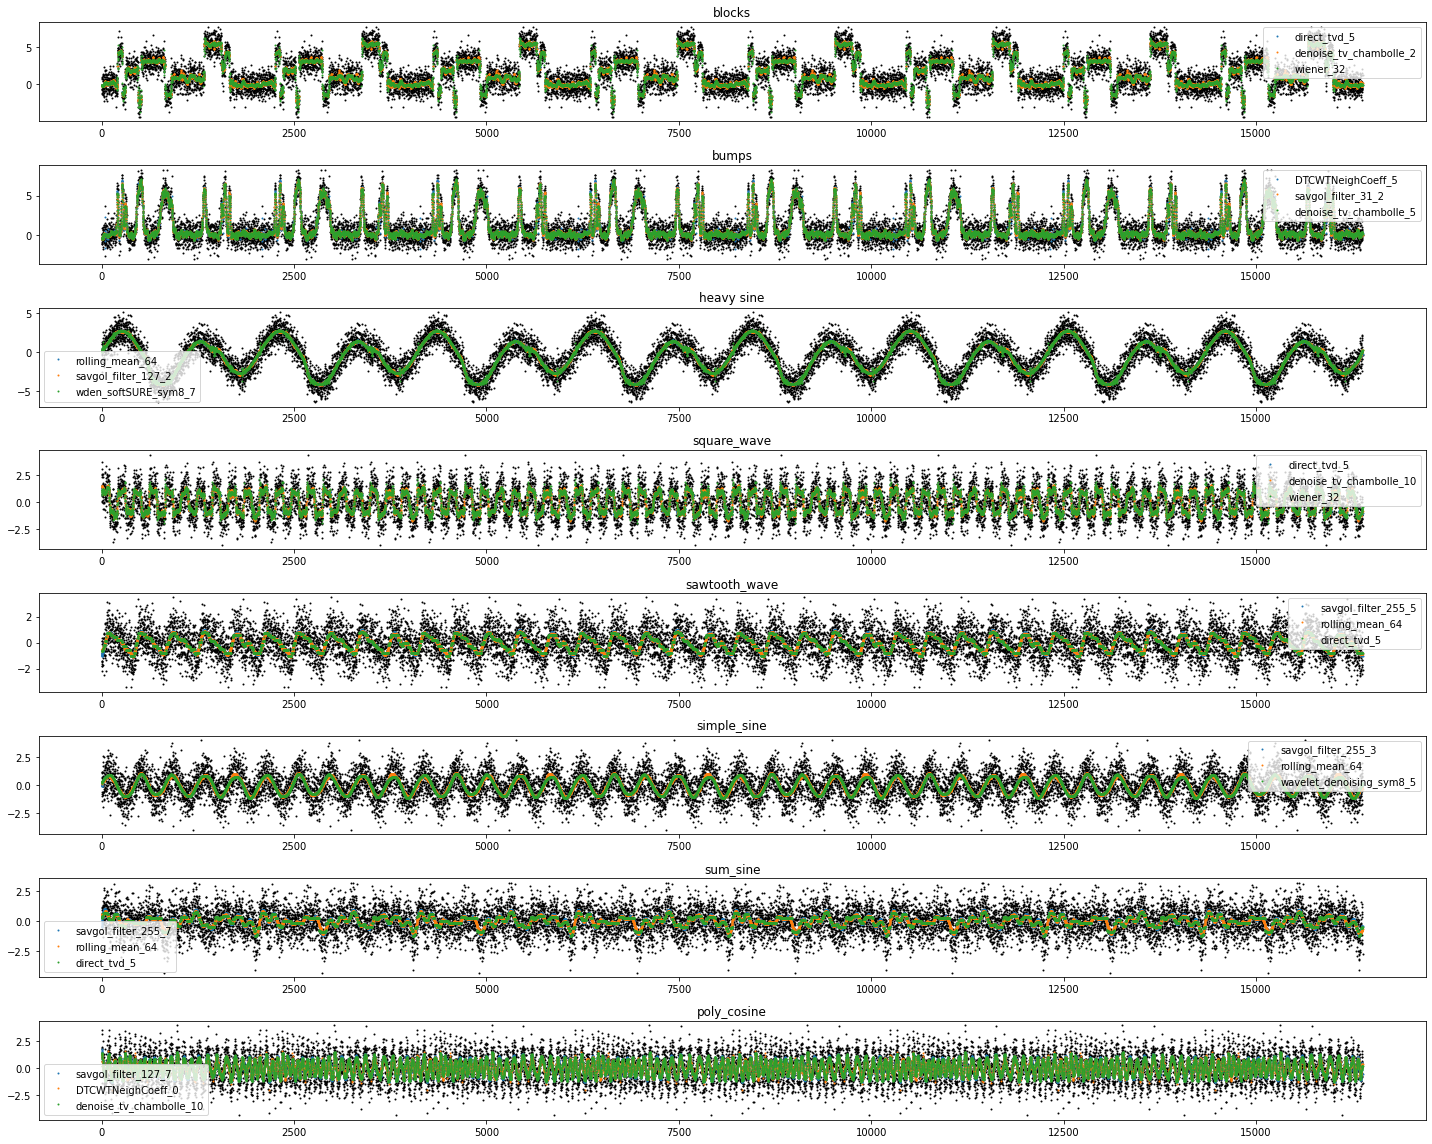

In [243]:
fig, axs = plt.subplots(8, 1, figsize=(20, 16))

for ax, signal in zip(axs, noisy_sig2.keys()):
    ax.plot(noisy_sig2[signal], 'o', color='k', ms=1)
    func_names = df_ranks.loc[(df_ranks['rank'] <=3) & (df_ranks['signal'] == signal), ['func_params']].values.flatten()
    for name in func_names:
        x_den = denoised_signals[signal][name]
        ax.plot(x_den, 'o', ms=1, label=name)
    ax.legend()
    ax.set_title(signal)
plt.tight_layout()
plt.show()